In [ ]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=a4998feb3f343c6a9483e410a05ca974bc233d7144a77294338d011a4f6d023e
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def CRNN_model(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Conv2D(8, kernel_size=(1,3), dilation_rate=(1,2) , padding='same')(X_input)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1,2) ,padding='same')(X)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.2)(X)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.3)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final, name='CRNN_base')

  return model

def RNN_base(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X_input)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.4)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final)

  return model

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc', simple_mfcc=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc',simple_mfcc=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='mfcc', testing=True, simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 13, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 13, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 13, 50, 1)         0         
                                                         

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 391s 314ms/step - loss: 2.5727 - sparse_categorical_accuracy: 0.3007 - val_loss: 1.4306 - val_sparse_categorical_accuracy: 0.5843
Epoch 2/25
497/497 [==============================] - 85s 172ms/step - loss: 0.9072 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.5560 - val_sparse_categorical_accuracy: 0.8365
Epoch 3/25
497/497 [==============================] - 86s 172ms/step - loss: 0.5949 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.4302 - val_sparse_categorical_accuracy: 0.8742
Epoch 4/25
497/497 [==============================] - 81s 164ms/step - loss: 0.4708 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.3577 - val_sparse_categorical_accuracy: 0.8950
Epoch 5/25
497/497 [==============================] - 82s 164ms/step - loss: 0.4133 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.9067
Epoch 6/25
497/497 [==============================] - 85s 170ms/step - loss: 0.3668 

In [ ]:
CRNN_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CRNN_mfcc_uniq'))
#CRNN_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CRNN_mfcc_uniq'))

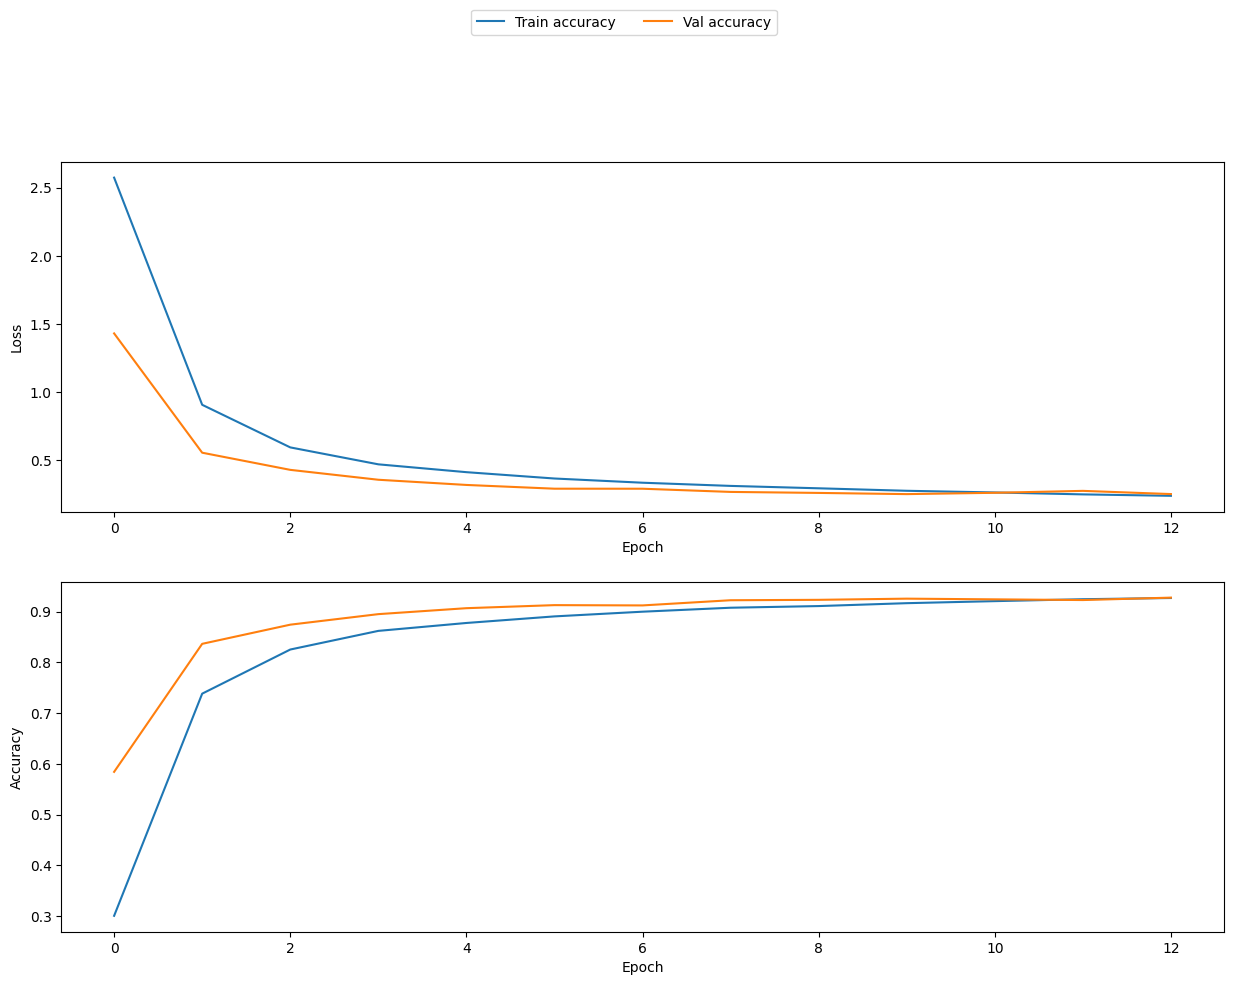

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 92s 551ms/step


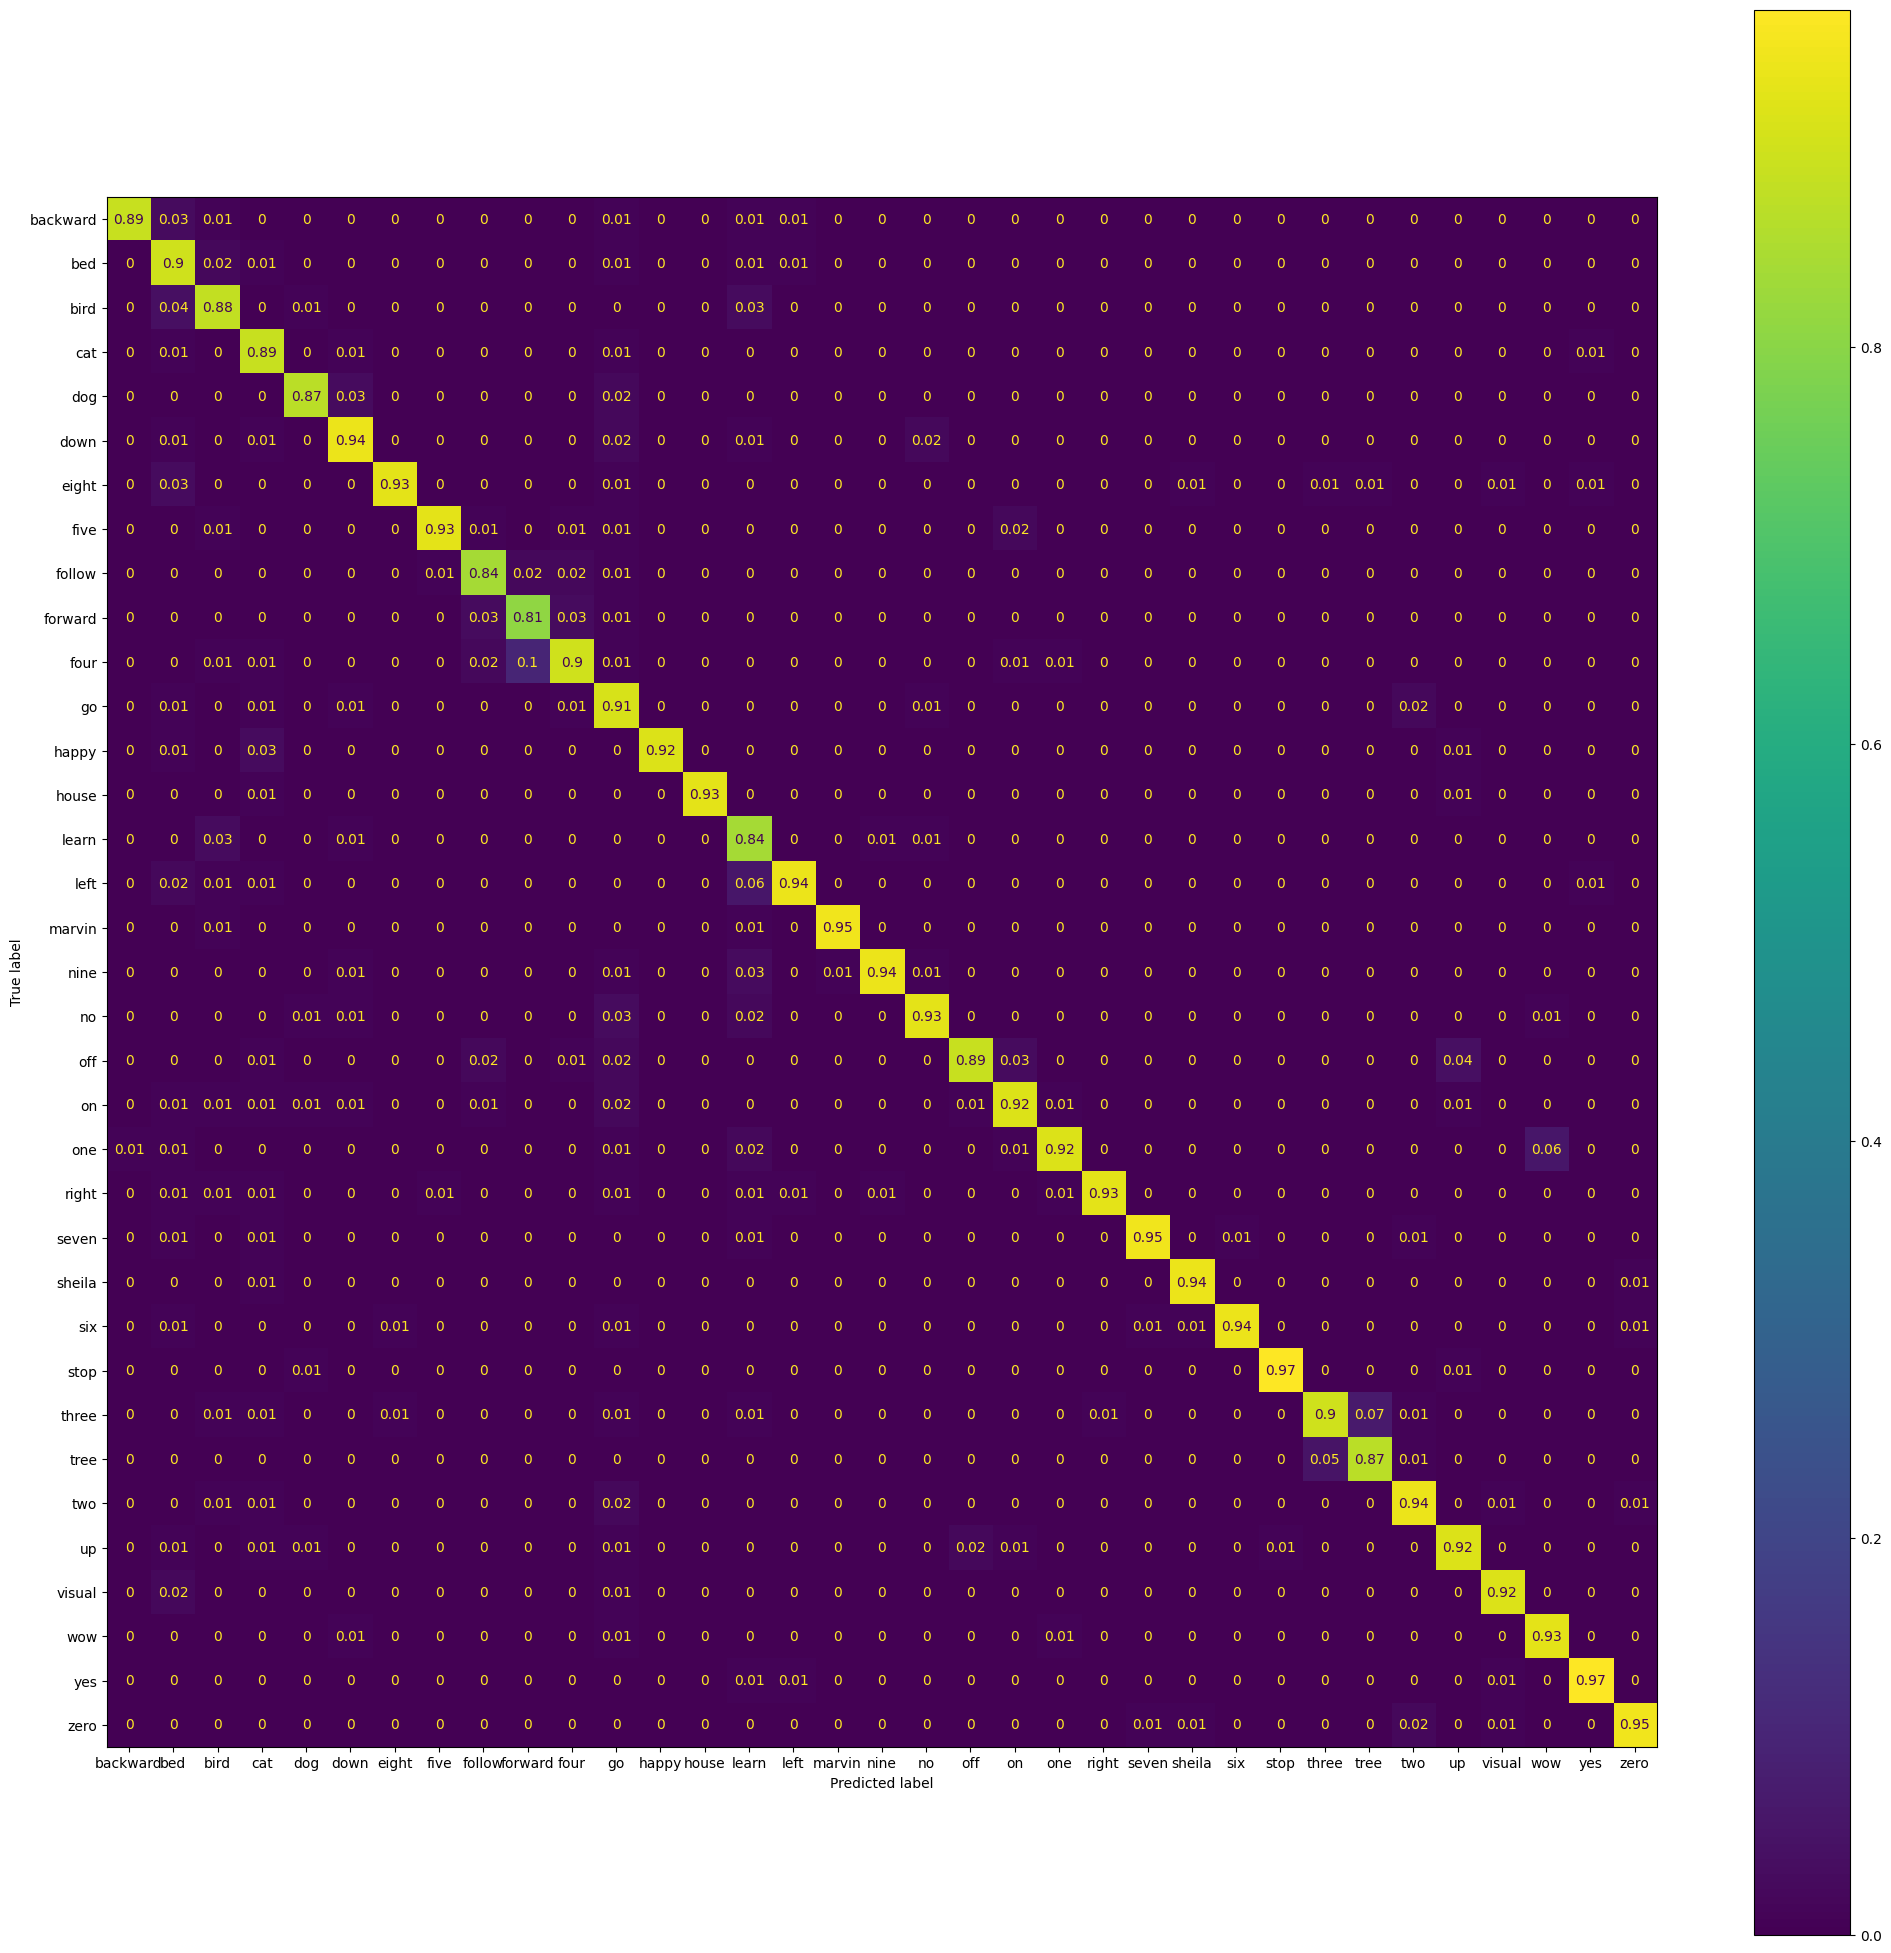

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.922096,0.914593,0.922718,0.922096,0.915939,0.92464,0.922096,0.918742,0.922096,0.922096,0.914593,CRNN_m


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 13, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 13)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           30336     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512 

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 78s 156ms/step - loss: 2.7627 - sparse_categorical_accuracy: 0.2828 - val_loss: 1.1768 - val_sparse_categorical_accuracy: 0.6698
Epoch 2/25
497/497 [==============================] - 75s 151ms/step - loss: 0.9280 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.6474 - val_sparse_categorical_accuracy: 0.8098
Epoch 3/25
497/497 [==============================] - 68s 136ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.8228 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.8448
Epoch 4/25
497/497 [==============================] - 72s 145ms/step - loss: 0.4773 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.4474 - val_sparse_categorical_accuracy: 0.8669
Epoch 5/25
497/497 [==============================] - 71s 143ms/step - loss: 0.4006 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8758
Epoch 6/25
497/497 [==============================] - 69s 138ms/step - loss: 0.3506 -

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('RNN_base_uniq'))
#RNN_base=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('RNN_base_uniq'))

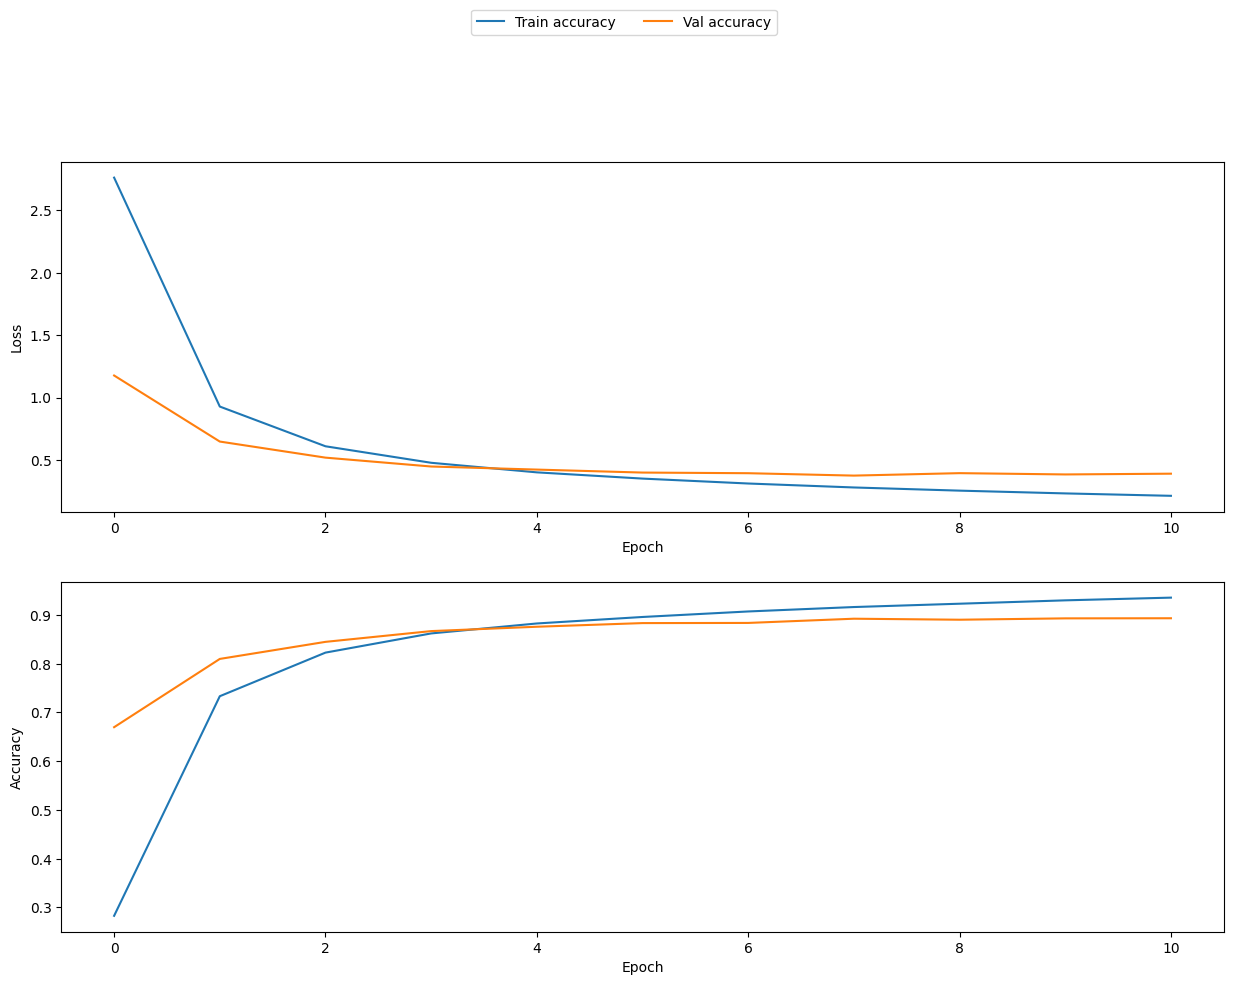

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 6s 36ms/step


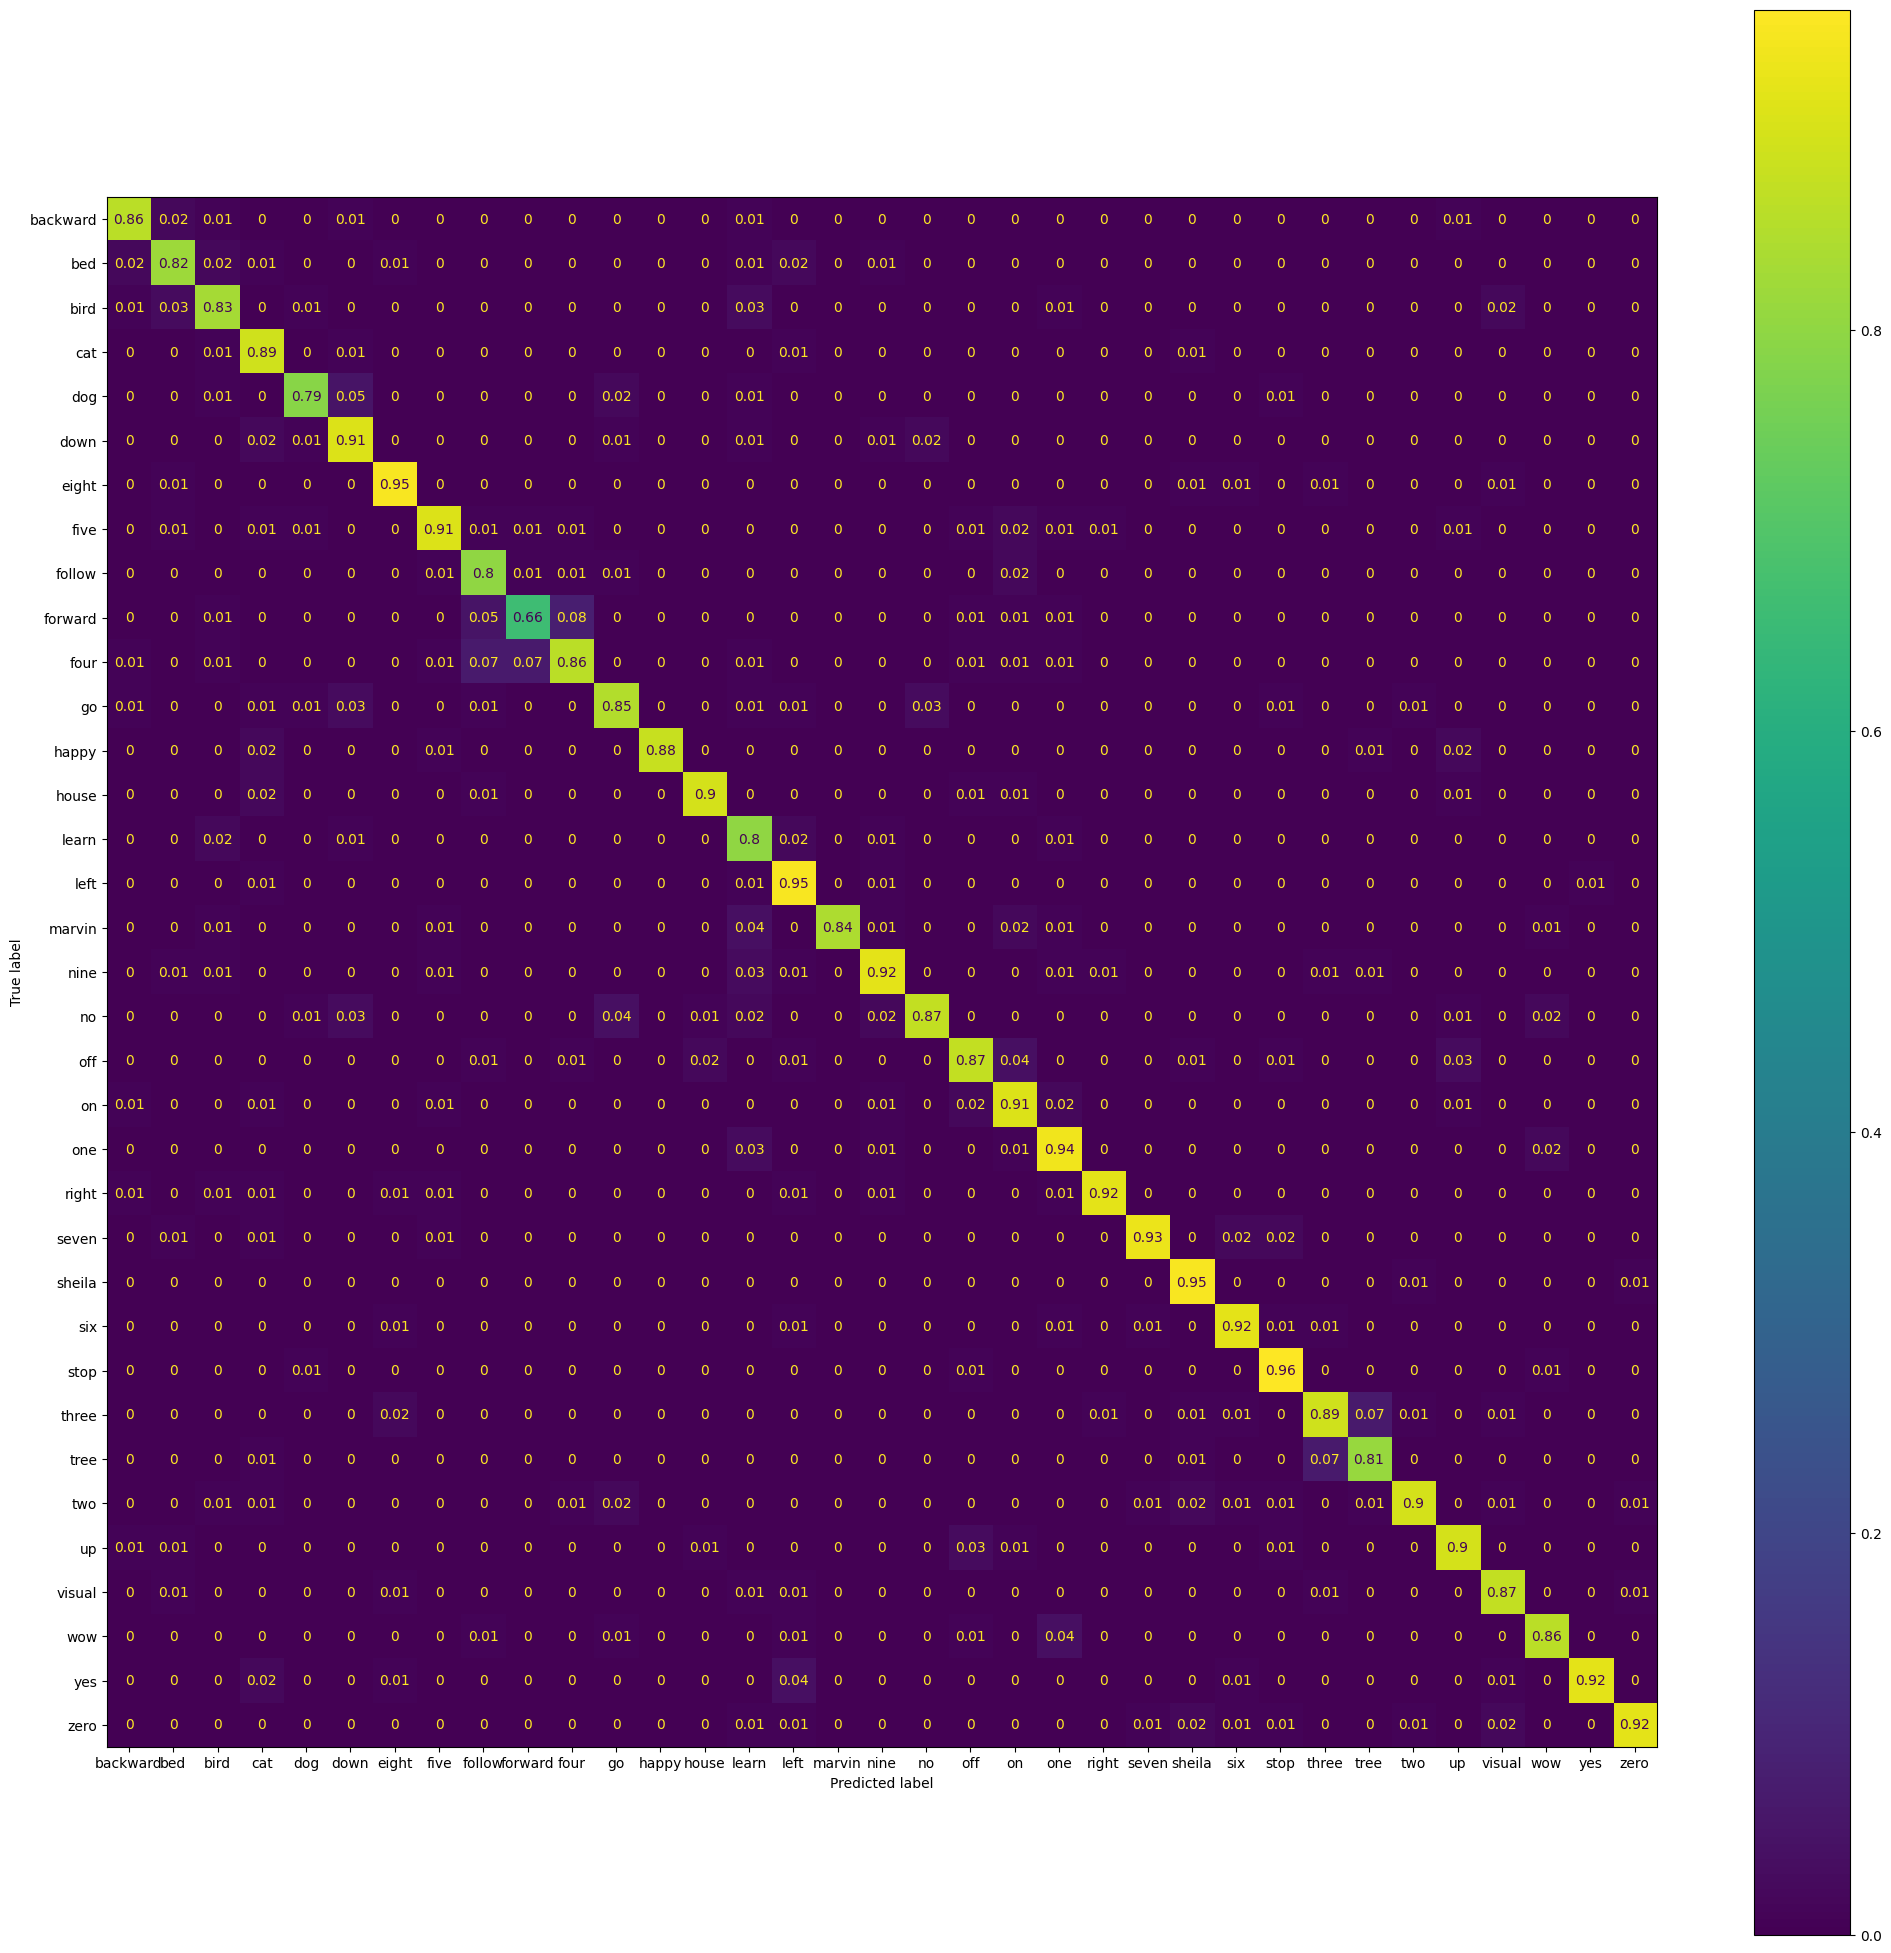

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.922096,0.914593,0.922718,0.922096,0.915939,0.924640,0.922096,0.918742,0.922096,0.922096,0.914593,CRNN_m
1,0.892096,0.879357,0.891883,0.892096,0.884408,0.893768,0.892096,0.892000,0.892096,0.892096,0.879357,RNN_base


**ANALYSIS ON NOISY DATASET**

In [ ]:
del perform, train_set, train_set_label, validation_set, validation_set_label, test_set, test_set_label,
del history_RNN_base, RNN_base, CRNN_m, history_CRNN_m

tf.keras.backend.clear_session()
gc.collect()


180

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True, cache_file_value='train_cache', type='mfcc', input_noise=True, simple_mfcc=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc', input_noise=True, simple_mfcc=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False, repeat=False, type='mfcc', testing=True, input_noise=True, simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 13, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 13, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 13, 50, 1)         0         
                                                         

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 489s 362ms/step - loss: 2.8219 - sparse_categorical_accuracy: 0.2130 - val_loss: 2.0451 - val_sparse_categorical_accuracy: 0.3799
Epoch 2/25
497/497 [==============================] - 89s 180ms/step - loss: 1.5664 - sparse_categorical_accuracy: 0.5335 - val_loss: 1.3492 - val_sparse_categorical_accuracy: 0.5852
Epoch 3/25
497/497 [==============================] - 91s 182ms/step - loss: 1.2032 - sparse_categorical_accuracy: 0.6391 - val_loss: 0.9932 - val_sparse_categorical_accuracy: 0.7002
Epoch 4/25
497/497 [==============================] - 91s 182ms/step - loss: 1.0532 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.9238 - val_sparse_categorical_accuracy: 0.7168
Epoch 5/25
497/497 [==============================] - 90s 180ms/step - loss: 0.9725 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.7466
Epoch 6/25
497/497 [==============================] - 87s 174ms/step - loss: 0.9093 

In [ ]:
CRNN_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CRNN_mfcc_noise'))
#mix_CNN_flog=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CRNN_mfcc_noise'))

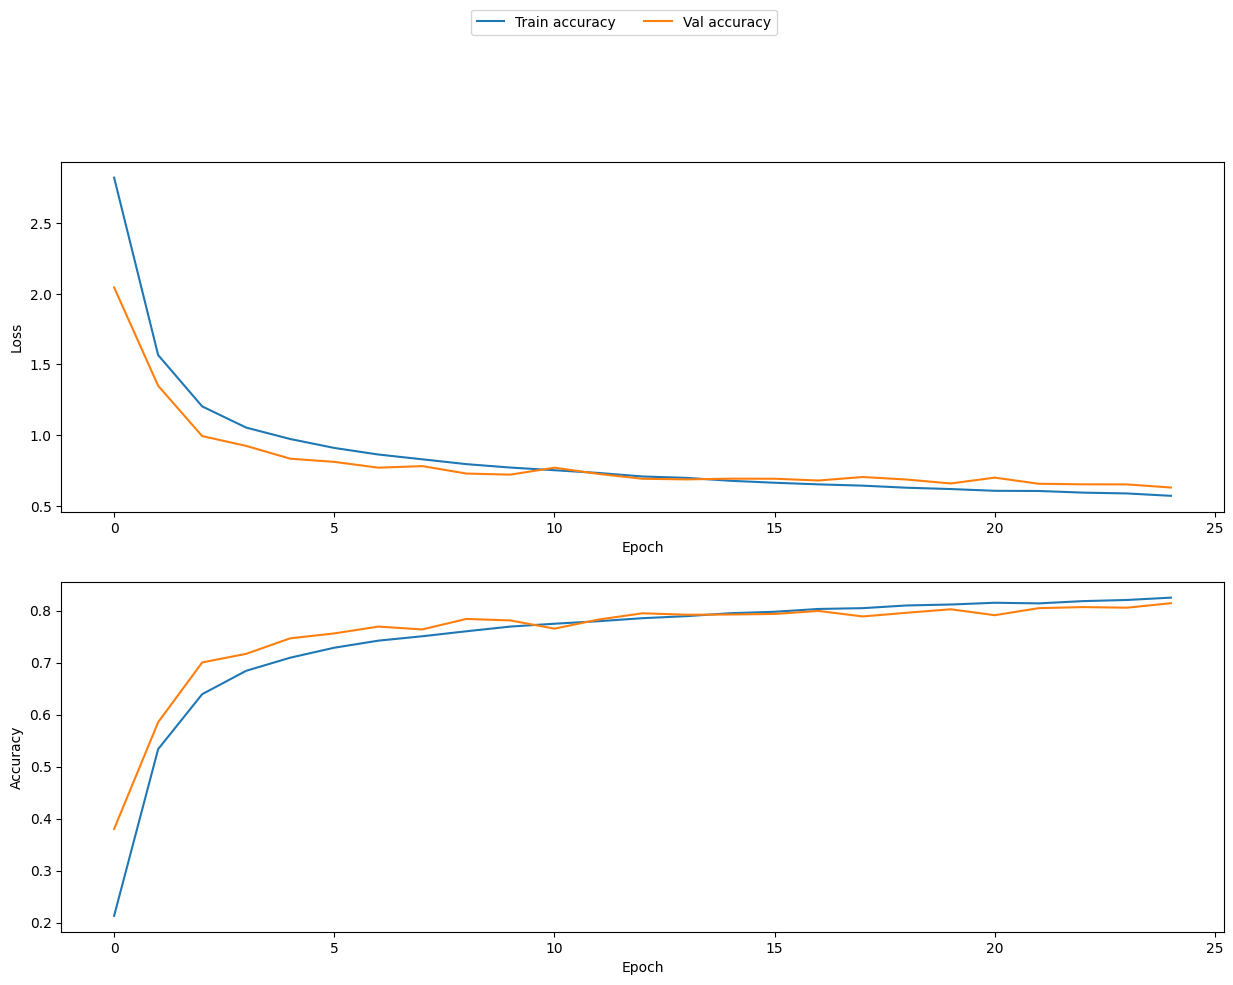

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 127s 747ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.814901,0.806764,0.815689,0.814901,0.810781,0.820491,0.814901,0.818724,0.814901,0.814901,0.806764,CRNN_m


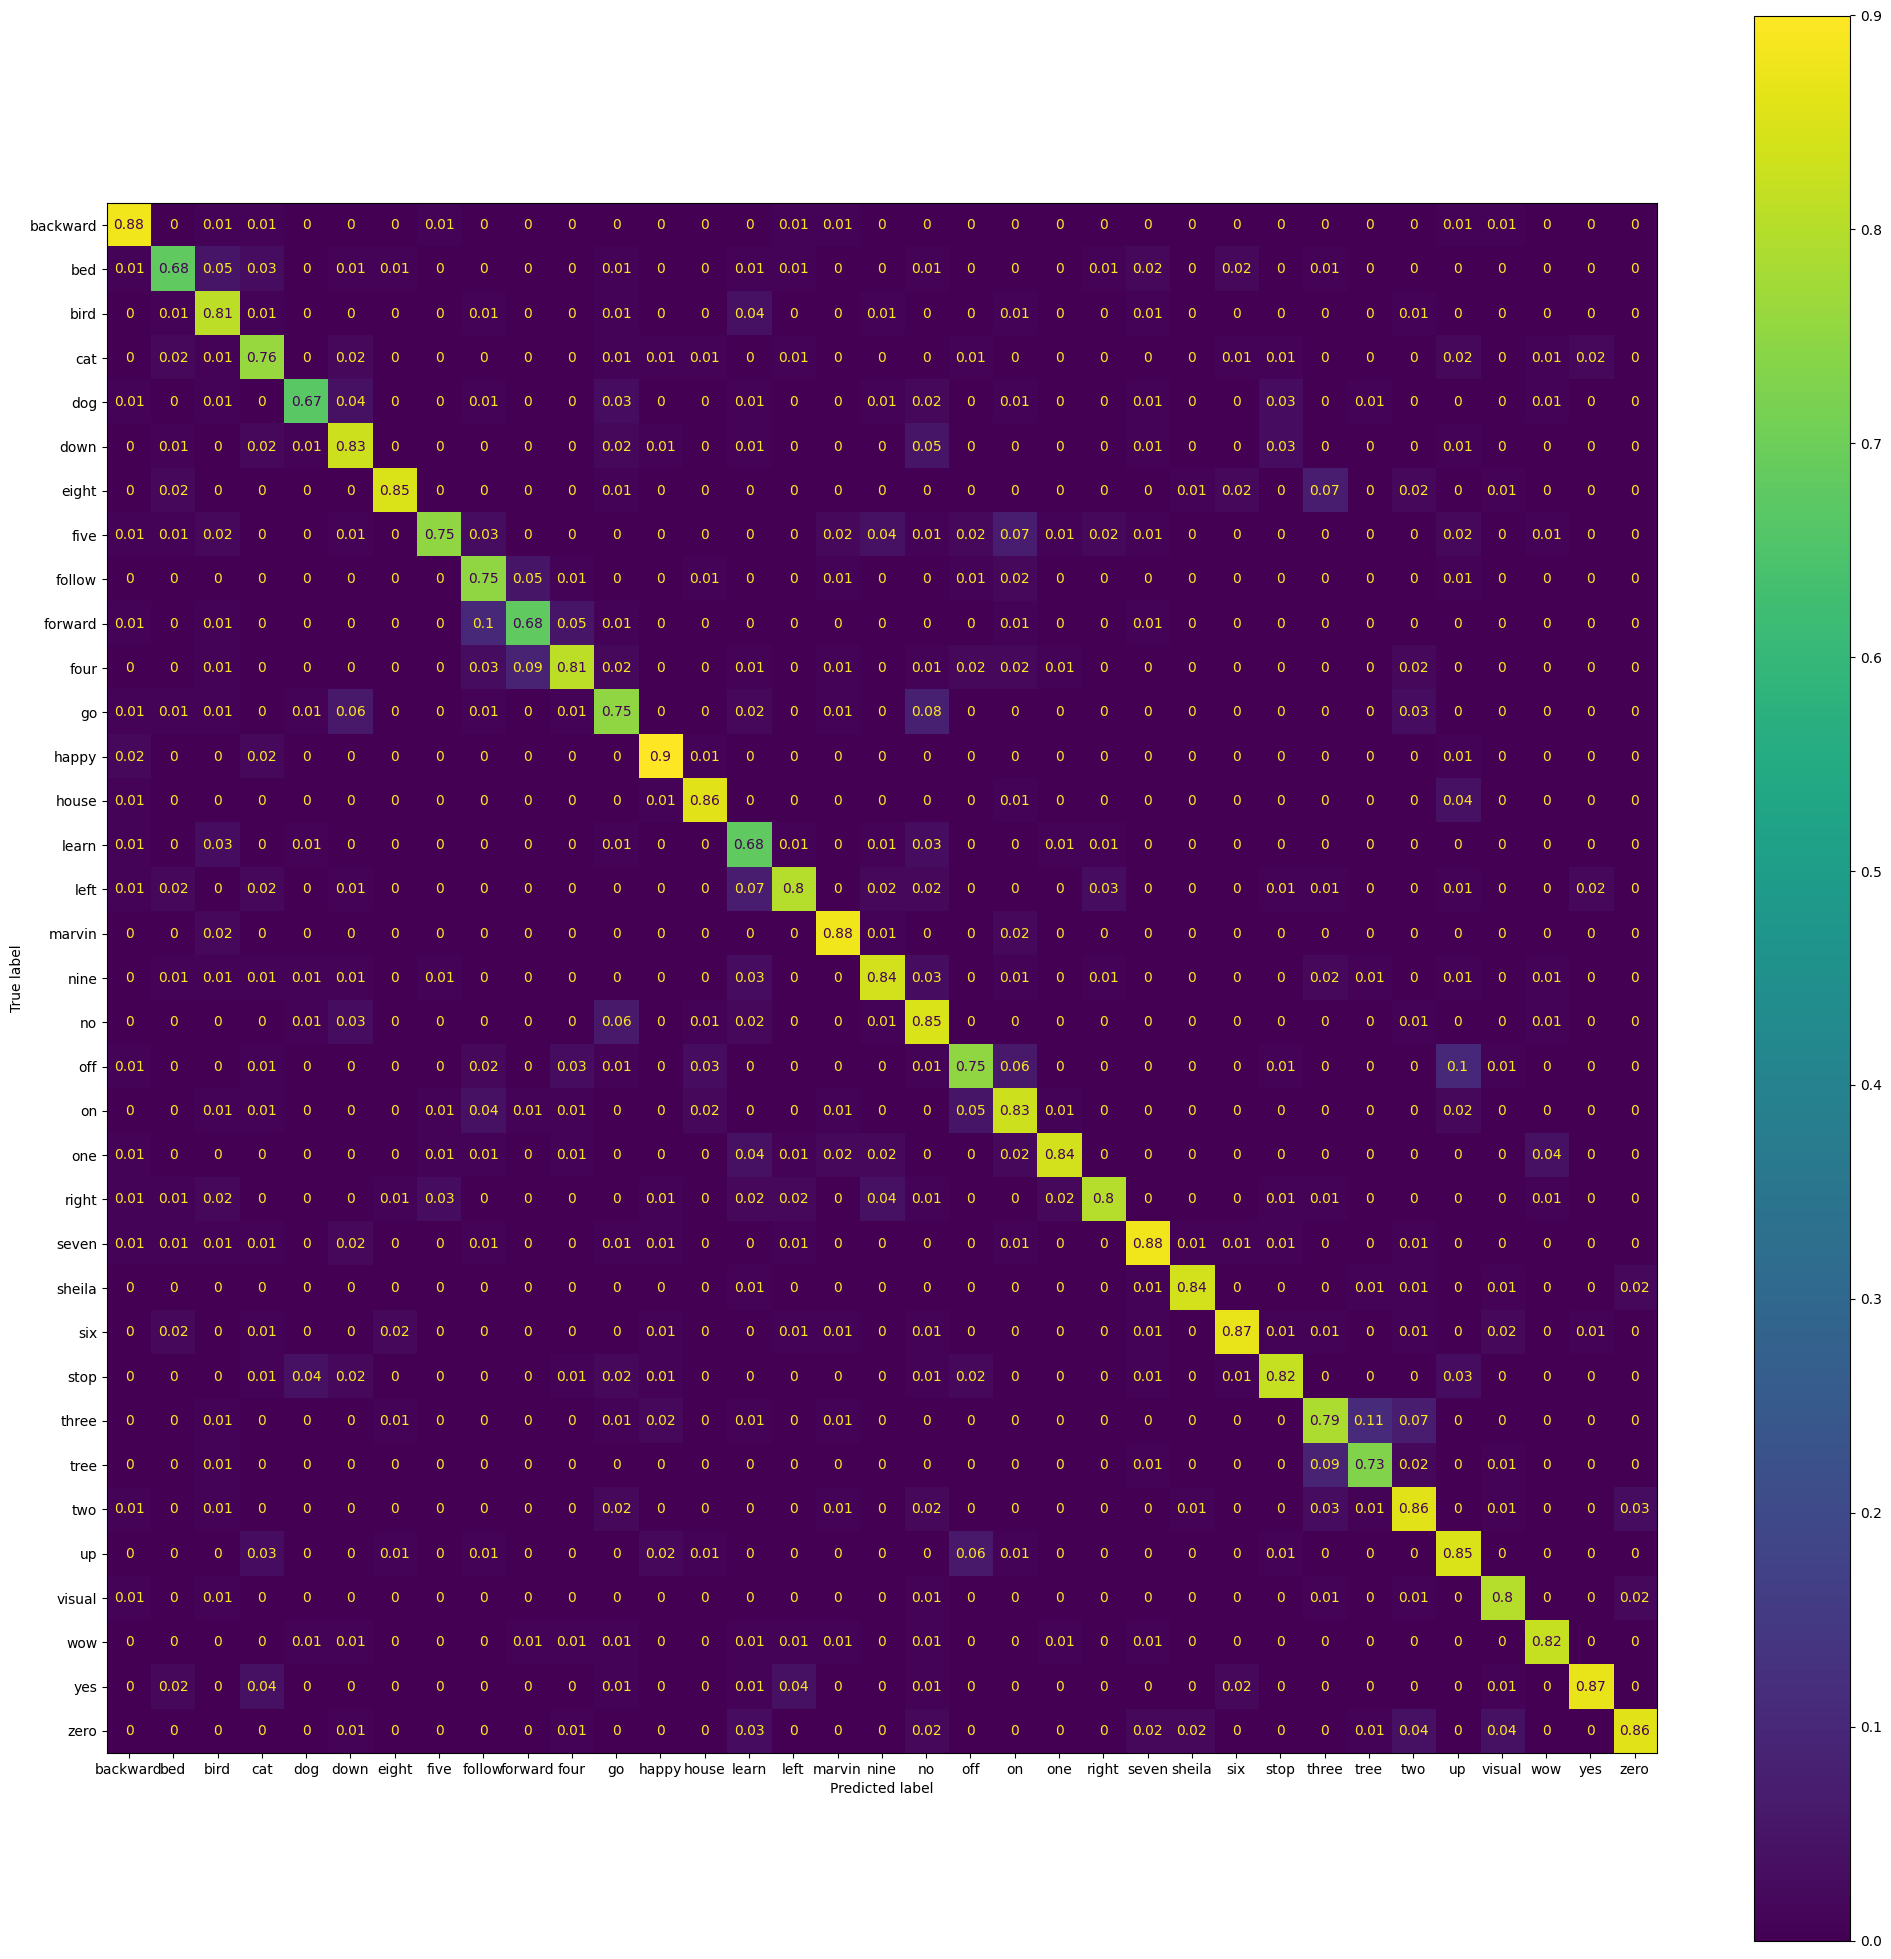

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 13, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 13)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           30336     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512 

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 76s 152ms/step - loss: 2.3508 - sparse_categorical_accuracy: 0.3369 - val_loss: 1.7172 - val_sparse_categorical_accuracy: 0.4839
Epoch 2/25
497/497 [==============================] - 77s 154ms/step - loss: 1.3605 - sparse_categorical_accuracy: 0.6020 - val_loss: 1.2874 - val_sparse_categorical_accuracy: 0.6285
Epoch 3/25
497/497 [==============================] - 76s 153ms/step - loss: 1.0915 - sparse_categorical_accuracy: 0.6802 - val_loss: 1.2846 - val_sparse_categorical_accuracy: 0.6411
Epoch 4/25
497/497 [==============================] - 75s 152ms/step - loss: 0.9493 - sparse_categorical_accuracy: 0.7198 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.6871
Epoch 5/25
497/497 [==============================] - 76s 152ms/step - loss: 0.8541 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.8692 - val_sparse_categorical_accuracy: 0.7426
Epoch 6/25
497/497 [==============================] - 73s 146ms/step - loss: 0.7881 -

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('RNN_base_mfcc_noisy'))
#RNN_base=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('RNN_base_mfcc_noisy'))

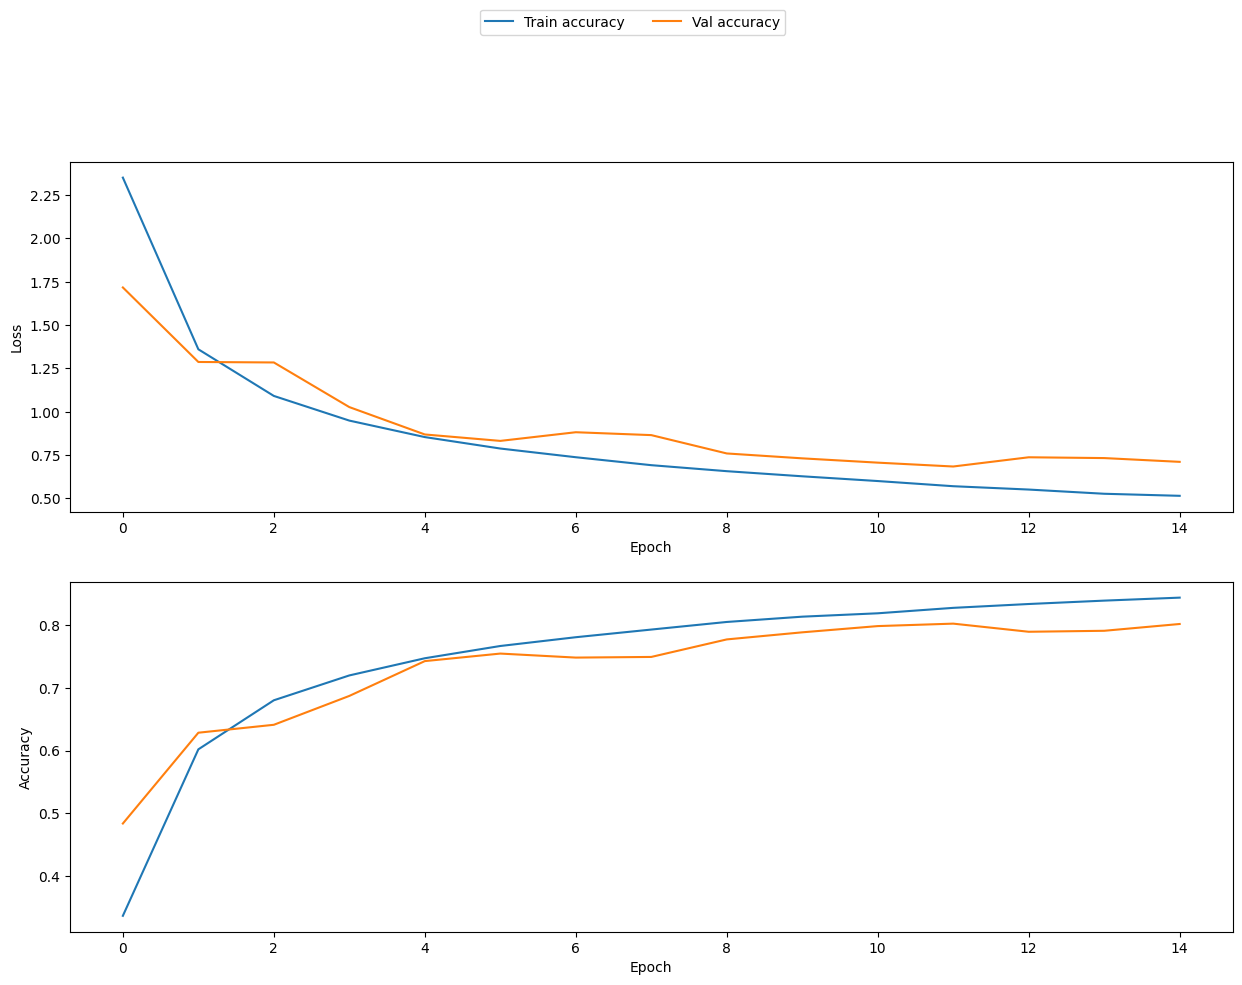

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 6s 36ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.814901,0.806764,0.815689,0.814901,0.810781,0.820491,0.814901,0.818724,0.814901,0.814901,0.806764,CRNN_m
1,0.803798,0.791837,0.804423,0.803798,0.795748,0.809962,0.803798,0.804901,0.803798,0.803798,0.791837,RNN_base
